# Facial Recognition Applied To Security
Bala, Charu, Prabhat

First part project report - link

This code is available at [https://github.com/baladutt/face].

## How To Run?
Main.ipynb is the jupyter notebook to run the project. Before running that,

* LFW dataset needs to be present in data directory. For example: data/lfw/Aaron_Eckhart/
* Download http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz into models/cnn

## Referenced Links
* https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/ * https://pypi.org/project/deepface/
* https://medium.com/@williamkoehrsen/facial-recognition-using-googles-convolutional-neural-network-5aa752b4240e * https://towardsdatascience.com/capsule-networks-the-new-deep-learning-network-bd917e6818e8

## Read Image data into memory

In [1]:
import time
import getpass
import warnings
warnings.filterwarnings('ignore')

username = getpass.getuser()
start_time = time.time()
#Where is the data?
if username == "bdutt":
    baseDir="/Users/bdutt/Documents/workspace-whitespace/face/face/data/lfw"
elif username =="cgarg":
    baseDir="/Users/cgarg/Documents/charu/intuit/code/face/data/lfw"
flow = "main"
debug = False

%run "Load Data.ipynb"

filenames = []
labels = []

def collectFileNamesAndLabels(filename):
    filenames.append(filename)
    result = filename.split("/") 
    labels.append(result[len(result)-2]) #Get the label name from filename
    
doForEachFile(collectFileNamesAndLabels,baseDir, 100)
print("Total File name collection time = %s seconds" % (time.time() - start_time))
print ("Files collected : ",len(filenames))

Total File name collection time = 1.766144037246704 seconds
Files collected :  69


In [2]:
start_time = time.time()
imagesList = []
doForEachFileNames(readImage, filenames, imagesList)
print ("Images data collected : ",len(imagesList))
print("Total data collection time = %s seconds" % (time.time() - start_time))

Images data collected :  69
Total data collection time = 0.13733601570129395 seconds


In [3]:
#%run "TransferLearningWithCNN.ipynb"

## Generic Multi threading code

Used later

In [4]:
import threading
import sys
import traceback
import time

class myThread (threading.Thread):
    def __init__(self, threadName, index, worker):
        threading.Thread.__init__(self)
        self.threadName = threadName
        self.index = index
        self.worker = worker
    def run(self):
        print('^',self.threadName, ', ', end='')
        try:
            self.worker(self.threadName, self.index)
        except:
            e = sys.exc_info()[0]
            print("Exception in thread: ",self.threadName,", ", e)
            traceback.print_exc()
        print('V',self.threadName, end='')
        

def runThreads(nThreads, worker):
    threads = []
    for i in range(nThreads):
        try:
            t = myThread("Thread-"+str(i), i , worker)
            threads.append(t)
            t.start()
        except:
            e = sys.exc_info()[0]
            print("Error: unable to start thread: ", e)
            traceback.print_exc()

    time.sleep(1)

    for t in threads:
        t.join()

In [5]:
start_time = time.time()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


Y = pd.DataFrame(labels, columns = ['name'])
sizeOfYLabel = len(Y)
oneDImageList = []
showOneImage = False

imageListLock = threading.Lock()

def flattenImage(image, imageList):
    # Convert RGB to single number
    global showOneImage
    if showOneImage:
        plt.imshow(image, cmap="Greys")
        plt.show()
    #gray = rgb2gray(image)
    gray = image
    if showOneImage:
        plt.imshow(gray, cmap="Greys")
        plt.show()
        showOneImage = False
    imageList.append(gray.flatten())

nThreads = 10
splitImagesList = np.array_split(imagesList, nThreads)
splitLabelsList = np.array_split(labels, nThreads)
labels = []

def imageFlatteningWorker(threadName, index):
    global splitImagesList
    global imageListLock
    imageList = []
    for image in splitImagesList[index]:
        flattenImage(image, imageList)
    imageListLock.acquire()
    global oneDImageList
    oneDImageList.extend(imageList)
    global labels
    labels.extend(splitLabelsList[index])
    imageListLock.release()

runThreads(nThreads, imageFlatteningWorker)
    
del imagesList

X = pd.DataFrame(oneDImageList)
del oneDImageList
print("X shape", X.shape)
print("label count", len(labels))
print("Total dataframe creation time = %s seconds" % (time.time() - start_time))

^ Thread-0 , ^ ^Thread-1 ,  Thread-2 , ^ Thread-3 , ^ Thread-4 , ^V  Thread-0Thread-5^ , ^ Thread-6 , V Thread-7 ,  VVThread-2 Thread-3 ^VThread-1 Thread-8 ,  Thread-4^ Thread-9 , V Thread-6V Thread-5VV Thread-8 Thread-7V Thread-9X shape (69, 187500)
label count 69
Total dataframe creation time = 15.45113205909729 seconds


In [6]:
#Y['name'].value_counts()

In [7]:
start_time = time.time()
maxFrequency = 21

# We upsample/downsample to have equal quantity of all classes

#X_sample = pd.DataFrame(columns = X.columns)
#Y_sample = pd.DataFrame(columns = Y.columns)
X_sampleList = []
Y_sampleList = []

XY_sampleLock = threading.Lock()

def equalSampleLabel(label):
    global X_sampleList
    global Y_sampleList
    global XY_sampleLock
    dfa = X[Y['name']== label]
    dfasample = dfa.sample(n=maxFrequency,replace=True)
    dfb = Y[Y['name']== label]
    dfbsample = dfb.sample(n=maxFrequency,replace=True)
    print('.', end='')
    XY_sampleLock.acquire()
    print('-', end='') 
    X_sampleList.append(dfasample)
    Y_sampleList.append(dfbsample)
    XY_sampleLock.release()
    print('+', end='')



labels = Y['name'].unique()

nThreads = 10
labelsArray = np.array_split(labels, nThreads)

def worker(threadName, index):
    for label in labelsArray[index]:
        #print(threadName, label)
        equalSampleLabel(label)

runThreads(nThreads, worker)

X_sample = pd.concat(X_sampleList)
Y_sample = pd.concat(Y_sampleList)
print(X_sample.shape)
print(Y_sample.shape)
X = X_sample
Y = Y_sample
# print(X_sample)
print("Total equal sampling time = %s seconds" % (time.time() - start_time))

^ Thread-0 , ^ Thread-1 , ^ Thread-2 , ^ Thread-3 , ^ Thread-4 , ^ Thread-5 , ^ Thread-6 , ^^ Thread-8 ,  ^Thread-7 ,  Thread-9 , ..-+-+.-+.-+.-..+-+..-+-+.-+-+.-+..-+-+.-+.-+.-+.-+V Thread-3.-+.-.+-+.-+V Thread-4..-+V Thread-6-+.-+.-.+-+V Thread-8.-+.-+V Thread-9.-+V Thread-5.-+V Thread-7.-+V Thread-0.-+V Thread-1.-+V Thread-2(693, 187500)
(693, 1)
Total equal sampling time = 2.3603718280792236 seconds


In [8]:
start_time = time.time()
sizeOfX = X_sample.shape[1]
#%run "DNN.ipynb"

print("Total DNN time = %s seconds" % (time.time() - start_time))

Total DNN time = 7.796287536621094e-05 seconds


In [9]:
print(X_sample.shape)


(693, 187500)


In [10]:
# print(Y)
# enc.get_feature_names(['name'])
# print(enc.get_feature_names(['name']).shape)

In [11]:
# import numpy as np
# import tensorflow as tf

# Ypred = pd.DataFrame( columns = ['sampleId', "classAsIndex", "classAsString", "actualClass"])
# for i in range(300):
#     prediction = model.predict(X_sample.iloc[i:i+1,:],verbose=0)
#     class_labels = np.argmax(prediction[0], axis=0)
#     Ypred.at[i, 'sampleId']  = i
#     Ypred.at[i, 'classAsIndex']  = class_labels
#     Ypred.at[i, 'classAsString']  = enc.get_feature_names(['name'])[class_labels]
#     Ypred.at[i, 'actualClass']  = Y_sample.iloc[i].values
#     #print(class_labels, enc.get_feature_names(['name'])[class_labels]," Names of class :: ", Y_sample.iloc[i].values)

# from IPython.display import display, HTML
# display(HTML(Ypred.to_html()))

In [12]:

class_mapping = { i : labels[i] for i in range(0, len(labels) ) }
print(class_mapping)

inv_class_mapping = {v: k for k, v in class_mapping.items()}
print(inv_class_mapping)
# print(type(inv_class_mapping))
# print(inv_class_mapping['0'])

{0: 'German_Khan', 1: 'Stefano_Gabbana', 2: 'Dragan_Covic', 3: 'Jeff_Hornacek', 4: 'Sureyya_Ayhan', 5: 'Deb_Santos', 6: 'Bob_Newhart', 7: 'Wang_Hailan', 8: 'Paul_McNulty', 9: 'Jimmy_Iovine', 10: 'Claudia_Pechstein', 11: 'Ranil_Wickremasinghe', 12: 'Ben_Chandler', 13: 'Mark_Komara', 14: 'Rand_Beers', 15: 'Joanne_Woodward', 16: 'John_Bond', 17: 'Reginald_Hudlin', 18: 'Lee_Baca', 19: 'Mary-Kate_Olsen', 20: 'Emily_Stevens', 21: 'Xiang_Huaicheng', 22: 'Phil_Mickelson', 23: 'Gerry_Kelly', 24: 'Salma_Hayek', 25: 'Jim_Edmonds', 26: 'Martina_McBride', 27: 'Anthony_Pico', 28: 'Jose_Theodore', 29: 'Heidi_Fleiss', 30: 'Mark_Richt', 31: 'Mike_Smith', 32: 'Paul_ONeill'}
{'German_Khan': 0, 'Stefano_Gabbana': 1, 'Dragan_Covic': 2, 'Jeff_Hornacek': 3, 'Sureyya_Ayhan': 4, 'Deb_Santos': 5, 'Bob_Newhart': 6, 'Wang_Hailan': 7, 'Paul_McNulty': 8, 'Jimmy_Iovine': 9, 'Claudia_Pechstein': 10, 'Ranil_Wickremasinghe': 11, 'Ben_Chandler': 12, 'Mark_Komara': 13, 'Rand_Beers': 14, 'Joanne_Woodward': 15, 'John_Bond'

## Invoke Inception Neural Network with Transfer Learning

In [13]:
from PIL import Image
import pandas as pd
import tensorflow as tf
print(X_sample.shape)
sample_dict = {}

X_transfer_learning = pd.DataFrame()

for ind in X_sample.index: 
    X_sample_array = X_sample.iloc[ind].as_matrix()
    arr = X_sample_array.reshape(250,250,3)
    img = tf.keras.preprocessing.image.array_to_img(arr)
    img.resize(size=(299,299), resample=Image.BICUBIC)
    array = tf.keras.preprocessing.image.img_to_array(img)
    sample_dict[0] = array
    X_transfer_learning = X_transfer_learning.append(sample_dict,ignore_index=True)

print(X_transfer_learning.shape)
print(X_transfer_learning[0][0].shape)
print(type(X_transfer_learning))
# Swap rows and columns of dataframe
# X_transfer_learning = X_transfer_learning.transpose()
# print(X_transfer_learning.shape)

(693, 187500)
(693, 1)
(250, 250, 3)
<class 'pandas.core.frame.DataFrame'>


In [14]:
label_y_sample = Y_sample.copy()
label_y_sample['name'] = label_y_sample['name'].map(inv_class_mapping)
class_images = label_y_sample['name'].value_counts()

Shape of Input to Transfer learning: X:  (693, 1) , Y:  (693, 1)
(299, 299, 3)


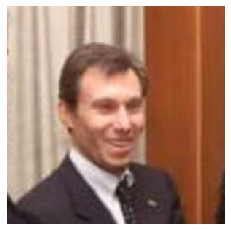

valid data shapes, X_valid:  (693, 299, 299, 3) , y_valid:  (693,)
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 149, 149, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 149, 149, 32) 0           batch_normalization_203[0][0]    
_____________

Total params: 55,873,736
Trainable params: 55,813,192
Non-trainable params: 60,544
__________________________________________________________________________________________________


Instructions for updating:
Use keras.layers.dense instead.
Done setup with n_outputs:  33
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/cnn/inception_v3.ckpt
Epoch:    1 Validation Loss: 45.4960 Accuracy: 0.060606
Epoch:    2 Validation Loss: 29.0928 Accuracy: 0.103896
Epoch:    3 Validation Loss: 20.5903 Accuracy: 0.121212
Epoch:    4 Validation Loss: 17.4955 Accuracy: 0.092352
Epoch:    5 Validation Loss: 11.2117 Accuracy: 0.121212
Epoch:    6 Validation Loss: 9.4862 Accuracy: 0.102453
Epoch:    7 Validation Loss: 8.3111 Accuracy: 0.121212
Epoch:    8 Validation Loss: 5.5791 Accuracy: 0.109668
Epoch:    9 Validation Loss: 5.5180 Accuracy: 0.121212
Epoch:   10 Validation Loss: 4.4001 Accuracy: 0.121212
Epoch:   11 Validation Loss: 4.7025 Accuracy: 0.121212
Epoch:   12 Validation Loss: 3.7889 Accuracy: 0.121212
Epoch:   13 Validation Loss: 3.8564 Accuracy: 0.121212
Epoch:   14 Validation Loss: 3.1

In [28]:
#print(Y_sample.shape)
#print(Y_sample)
warnings.filterwarnings('ignore')
start_time = time.time()
sizeOfX = X_sample.shape[1]
print("Shape of Input to Transfer learning: X: ", X_transfer_learning.shape, ", Y: ", Y_sample.shape)
%run "TransferLearning-New.ipynb"

print("Total transfer learning with CNN time = %s seconds" % (time.time() - start_time))

(299, 299, 3)


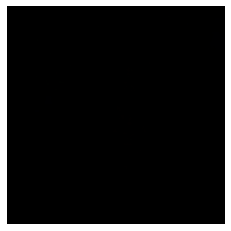

Text(0.5, 1.0, 'Original Image of Emily_Stevens')

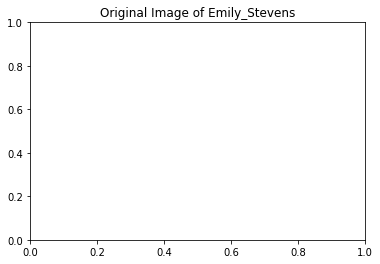

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

# Function to plot an array of RGB values 
def plot_color_image(image):
    plt.figure(figsize=(4,4))
    print(image.shape)
    plt.imshow(image.astype(np.uint8), interpolation='nearest')
    plt.axis('off')
    plt.show()
    
ex_index =0

plot_color_image(X_batch[ex_index])
plt.title('Original Image of {}'.format(class_mapping[y_batch[ex_index]]))


In [36]:
# from scipy.misc import imresize
from PIL import Image
# Function takes in an image array and returns the resized and normalized array
def prepare_image(image, target_height=299, target_width=299):
    if(type(image) == np.ndarray):
        plot_color_image(image[0])
        image = image[0].reshape(250,250,3)
        plot_color_image(image)
    else:   
        image = image.iloc[0].reshape(250,250,3)
    image = image.astype(np.uint8)
    image = np.array(Image.fromarray(obj=image, mode='RGB').resize(size=(target_height,target_width), resample=Image.BICUBIC))
    plot_color_image(image)
    
    return image.astype(np.float32) / 255

In [37]:
# Function takes in an array of images and labels and processes the images to create
# a batch of a given size
def create_batch(X, y, start_index=0, batch_size=4):
#     print("create batch : start_index:: ", start_index, "batch size:: ", batch_size)
    stop_index = start_index + batch_size
    prepared_images = []
    labels = []
 
    for index in range(start_index, stop_index):
        if(type(X) == np.ndarray):
            preparedImage = prepare_image(X[index]).reshape(299,299, 3)
        else:    
            preparedImage = prepare_image(X.iloc[index]).reshape(299,299, 3)
        dim = np.zeros((299,299))
        #preparedImage = np.stack((preparedImage,preparedImage, preparedImage), axis=-1)
        prepared_images.append(preparedImage)
        
        if(type(y) == np.ndarray):
            labels.append(int(y[index]))
        else:    
            labels.append(inv_class_mapping[y.iloc[index][0]])
 
 # Combine the images into a single array by joining along the 0th axis
    X_batch = np.stack(prepared_images)
    y_batch = np.array(labels, dtype=np.int32)
 
    return X_batch, y_batch

(250, 250, 3)


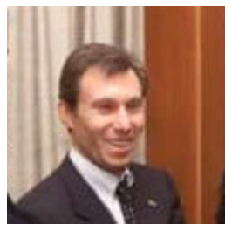

(250, 250, 3)


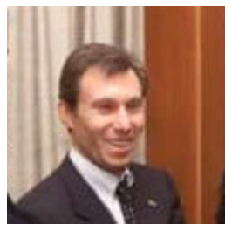

(299, 299, 3)


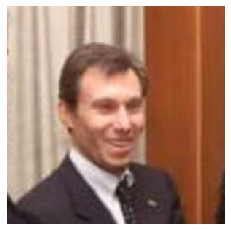

In [38]:
X_batch, y_batch = create_batch(X_train, y_train, 0, 1)